# Ford GoBike 2017 ride Analysis
## by Priyadarsini Mylsamy

## Preliminary Wrangling


Ford GoBike is a regional public bicycle sharing system in the San Francisco Bay Area, California. 
Its 540 stations and 7,000 bikes sprawl across five cities in San Francisco Bay Area. A docked bike can be checked out at any station and must be returned to a station when the trip is complete
The bikes are available for use 24 hours/day, 7 days/week, 365 days/year and riders can either subscribe and become members or can be casual users

In [61]:
# import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb


%matplotlib inline

### Data Gathering

In [62]:
# load  2018-fordgobike-tripdata.csv into a dataframe for analysis
bike_df = pd.read_csv('2017-fordgobike-tripdata.csv')
#bike_df=bike_df.sample()

### Data  Wrangling (Analysis and Clean Up)

In [63]:
#Explore the high level structure of this data

print(bike_df.shape)



(519700, 15)


In [64]:
print(bike_df.user_type.value_counts())
print(bike_df.member_gender.value_counts())

Subscriber    409230
Customer      110470
Name: user_type, dtype: int64
Male      348318
Female     98621
Other       6299
Name: member_gender, dtype: int64


#### check how many columns have null values

In [65]:
print(bike_df.isnull().sum())


duration_sec                   0
start_time                     0
end_time                       0
start_station_id               0
start_station_name             0
start_station_latitude         0
start_station_longitude        0
end_station_id                 0
end_station_name               0
end_station_latitude           0
end_station_longitude          0
bike_id                        0
user_type                      0
member_birth_year          66541
member_gender              66462
dtype: int64


#### Data does have  missing values for gender and member_birth_year
#### Few of these columns need to be changed to a different datatype to be used for meaningful analysis.
<li> start_time should be changed to datetime </li>
<li> end_time should be changed to datetime </li>
<li> user_type should be changed to category </li>
<li> member_gender should be changed to category </li>
<li> member_birth_year should be changed to int </li>



In [66]:
# Take a look at the first 5 rows of the data
print(bike_df.head())



   duration_sec                start_time                  end_time  \
0         80110  2017-12-31 16:57:39.6540  2018-01-01 15:12:50.2450   
1         78800  2017-12-31 15:56:34.8420  2018-01-01 13:49:55.6170   
2         45768  2017-12-31 22:45:48.4110  2018-01-01 11:28:36.8830   
3         62172  2017-12-31 17:31:10.6360  2018-01-01 10:47:23.5310   
4         43603  2017-12-31 14:23:14.0010  2018-01-01 02:29:57.5710   

   start_station_id                                 start_station_name  \
0                74                              Laguna St at Hayes St   
1               284  Yerba Buena Center for the Arts (Howard St at ...   
2               245                             Downtown Berkeley BART   
3                60                               8th St at Ringold St   
4               239                      Bancroft Way at Telegraph Ave   

   start_station_latitude  start_station_longitude  end_station_id  \
0               37.776435              -122.426244        

#### The dataset has some columns which we will not be using in our analysis.We will remove it from the dataframe to make it easy to work with.

#### Write functions to change the datatype of columns

In [67]:
#### function to change a column to datatime datatype
def convert_to_datetime(df, cnamelist):
    """ Takes dataframe and column name list to be converted as inputs and changes the data type of the columns to datetime"""
    for cname in cnamelist:
        df[cname] = pd.to_datetime(df[cname])
    

In [68]:
#### function to change a column to category
def convert_to_category(df,cname,categorieslist):
    """ Takes dataframe and column name and  list of categories  as inputs and changes the data type of the column to category"""
    df[cname] = df[cname].astype('category',ordered=True,categories=categorieslist)

In [69]:
#### function to change a column to int
def convert_to_int(df,cname):
    """ Takes dataframe and column name to be converted as inputs and changes the data type of the column to integer"""
    df[cname] = df[cname].astype(int)
    

#### Remove rows with Null values for member_gender and member_birth_year

In [70]:
#### We will remove columns with null values for gender and member birth year
gobike_df = bike_df.copy()
gobike_df = gobike_df[(pd.notna(gobike_df['member_gender'])) & (pd.notna(gobike_df['member_birth_year']))]

#### Using functions created earlier, change the data type of columns as noted in the analysis section

In [71]:
# start_time, end_time to datetime
convert_to_datetime(gobike_df, ['start_time','end_time'])

# user_type to category
convert_to_category(gobike_df,'user_type',['Subscriber','Customer'])

# member_gender to category
convert_to_category(gobike_df,'member_gender',['Male','Female','Other'])

# member_birth_year to int
convert_to_int(gobike_df,'member_birth_year')


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: specifying 'categories' or 'ordered' in .astype() is deprecated; pass a CategoricalDtype instead
  after removing the cwd from sys.path.


#### Test the datatypes and null values clean up

In [72]:
print(gobike_df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 453159 entries, 0 to 519699
Data columns (total 15 columns):
duration_sec               453159 non-null int64
start_time                 453159 non-null datetime64[ns]
end_time                   453159 non-null datetime64[ns]
start_station_id           453159 non-null int64
start_station_name         453159 non-null object
start_station_latitude     453159 non-null float64
start_station_longitude    453159 non-null float64
end_station_id             453159 non-null int64
end_station_name           453159 non-null object
end_station_latitude       453159 non-null float64
end_station_longitude      453159 non-null float64
bike_id                    453159 non-null int64
user_type                  453159 non-null category
member_birth_year          453159 non-null int64
member_gender              453159 non-null category
dtypes: category(2), datetime64[ns](2), float64(4), int64(5), object(2)
memory usage: 49.3+ MB
None


In [73]:

#### let us do a quick duplicate check
gobike_df.duplicated().sum()


0

#### We do not have duplicate rows.Let us remove duplicate rows

#### All the datatypes have been changed and rows with null values of member_gender and member_birth_year have been removed 

#### We will create a new column called member_age since that will give more meaningful insight in our analysis than the birth year of the member

In [74]:
gobike_df['member_age'] = pd.datetime.now().year -  gobike_df['member_birth_year'] 

In [75]:
### A function to create derived columns for start_time and end_time
        
def create_month_day_weekday_hour(df,collist):
    """This function takes a list of datetime column names and creates derived columns (month,monthname,weekday,day,hour)
    in the dataframe"""
    for colname in collist:
        df[colname + '_month_name']=df[colname].dt.strftime('%B')
        df[colname + '_month']= df[colname].dt.month.astype(int)
        df[colname + '_weekday']=df[colname].dt.strftime('%a')
        df[colname+ '_day']= df[colname].dt.day.astype(int)
        df[colname+ '_hour']= df[colname].dt.hour
    
    

#### Call the function to create derived columns (start_time_hour,start_time_month,start_time_day,start_time_weekday,start_time_onth)

In [76]:
## Let us create few more derived columns for start_time and end_time  that will help us in our analysis
create_month_day_weekday_hour(gobike_df,['start_time','end_time'])

In [77]:
gobike_df.head()
print(gobike_df.start_time_day.value_counts())
print(gobike_df.start_time_hour.value_counts())
print(gobike_df.start_time_month_name.value_counts())
print(gobike_df.start_time_weekday.value_counts())
print(gobike_df.start_time_month.value_counts())



6     16960
14    16934
20    16854
7     16831
18    16670
28    16519
13    16456
11    16279
21    16044
27    15932
30    15473
19    15215
29    15117
12    15042
8     14961
17    14950
5     14925
15    14883
1     14787
25    13911
10    13533
9     13499
22    13351
26    13225
2     13161
4     13125
3     12925
16    12241
24    12193
23    11052
31    10111
Name: start_time_day, dtype: int64
8     54678
17    54620
9     42184
18    41752
16    35478
7     25656
19    23552
15    22491
12    21760
13    21155
10    20999
11    19139
14    18902
20    14628
21    10362
6      8520
22     6689
23     4012
0      2105
5      2018
1      1043
4       578
2       578
3       260
Name: start_time_hour, dtype: int64
October      95316
November     86090
September    85437
December     78236
August       69783
July         35910
June          2387
Name: start_time_month_name, dtype: int64
Tue    80482
Wed    80357
Thu    77198
Mon    73536
Fri    72018
Sat    36780
Sun    32788
Nam

#### change the datatype of derived columns to category

In [78]:
## Change the datatype of start_time_day, start_time_hour,start_time_weekday,start_time_month,start_time_month_name to category


# start_time_day to category
convert_to_category(gobike_df,'start_time_day',[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31])

# start_time_hour to category
convert_to_category(gobike_df,'start_time_hour',[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23])

#start_time_month_name to category
convert_to_category(gobike_df,'start_time_month_name',['June','July','August','September','October','November','December'])

#start_time_weekday to category
convert_to_category(gobike_df,'start_time_weekday',['Mon','Tue','Wed','Thu','Fri','Sat','Sun'])


#start_time_month to category
convert_to_category(gobike_df,'start_time_month',[6,7,8,9,10,11,12])

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: specifying 'categories' or 'ordered' in .astype() is deprecated; pass a CategoricalDtype instead
  after removing the cwd from sys.path.


#### We will not be using start_station_latitude and start_station_longitude, end_station_latitude, end_station_latitude in our analysis so we will remove them

In [79]:
### Drop columns not required for our analysis
gobike_df.drop(columns=['start_station_latitude','start_station_longitude','end_station_latitude','end_station_longitude'],inplace=True)


In [80]:
### test if columns have been dropped
print(gobike_df.shape)
print(min(gobike_df['start_time']))
print(max(gobike_df['start_time']))

(453159, 22)
2017-06-28 09:47:36.347000
2017-12-31 23:59:01.261000



### What is the structure of your dataset?

There are 453159 entries of bike rides from 2017-06-28 to 2017-12-31 in the dataset with 11 columns (duration_sec,start_time,end_time,start_station_id,start_station_name,end_station_id,end_station_name,bike_id,user_type,member_birth_year,member_gender) and 11 derived columns

### What is/are the main feature(s) of interest in your dataset?
 We would like to explore this data set to explore the following 
 <ul>
<li>When are most trips taken in terms of time of day, day of the week, or month of the year?<li>
<li>How long does the average trip take?<li>
<li>Does the no of trips or duration of a trip depend on the user being a subscriber or customer?<li>
<li>What is the ratio of male and female users?<li>
<li>What is the median age of users?<li>
<li>What is distribution of ride duration?<li>
<li>Identify the user base who can be approached through promotions to become members.<li>
</ul>

### What features in the dataset do you think will help support your investigation into your feature(s) of interest?

<li>I think ride duration is a very useful column which when layered with time of the ride and type of user can give us a very good indication of ride characteristics of subscribed users and casual users.</li>
<li> Columns like gender and age can also help us understand our user base.</li>
<li> Analysis of all these variables will help us come up with suitable recommendations on the different ways by which ridership can be increased.</li>


## Univariate Exploration

I'll start by looking at the distribution of the main variable of interest: duration_sec.


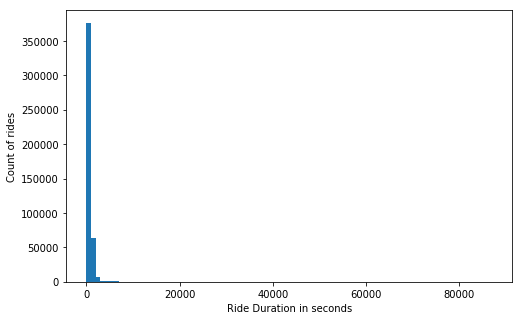

In [81]:
# start with a standard-scaled plot
binsize = 1000
bins = np.arange(0, gobike_df['duration_sec'].max()+binsize, binsize)

plt.figure(figsize=[8, 5])
plt.hist(data = gobike_df, x = 'duration_sec', bins = bins)
plt.xlabel('Ride Duration in seconds')
plt.ylabel('Count of rides')
plt.show()


#### we definitely have a lot of outliers.Let us find them and clean the data set to explore the distribution better

In [82]:
print(len(gobike_df[gobike_df.duration_sec > 15000]))

1458


Since this is a very small % compared to our data set length, I will be removing these outliers to analyze our data better

In [83]:
gobike_df = gobike_df[gobike_df.duration_sec < 15000]

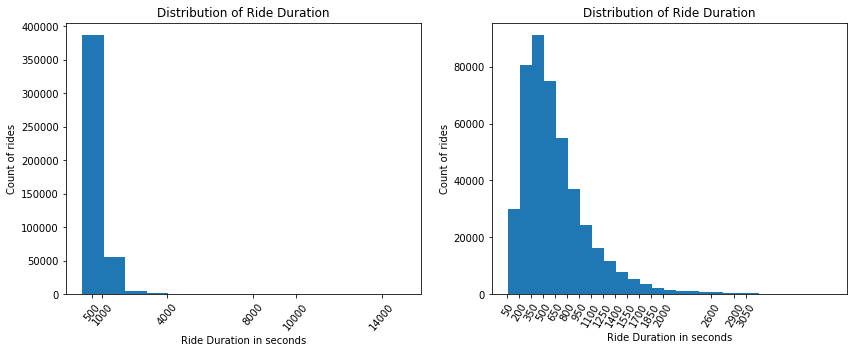

In [84]:
# start with a standard-scaled plot
plt.figure(figsize=[14,5])
plt.subplot(1,2,1)
binsize = 1000
bins = np.arange(gobike_df['duration_sec'].min(), gobike_df['duration_sec'].max()+binsize, binsize)
plt.hist(data = gobike_df, x = 'duration_sec', bins = bins)
plt.xlabel('Ride Duration in seconds')
plt.ylabel('Count of rides')
plt.xticks([500,1000,4000,8000,10000,14000],rotation=50)
plt.title('Distribution of Ride Duration')

plt.subplot(1,2,2)
binsize = 150
bins = np.arange(gobike_df['duration_sec'].min(), 4000+binsize, binsize)
plt.hist(data = gobike_df, x = 'duration_sec', bins = bins)
plt.xlabel('Ride Duration in seconds')
plt.ylabel('Count of rides')
plt.xticks([50,200,350,500,650,800,950,1100,1250,1400,1550,1700,1850,2000,2600,2900,3050],rotation=60)
plt.title('Distribution of Ride Duration')
plt.show()


#### Looking at both charts (histograms and box plots), we can see thats most of the rides start peaking between 200 s and 350 s and maximum rides are between 350 and 500s after which it starts dropping.Most of the rides last between 200s(3 minutes) to 650 s(11 minutes).This suggests thats most of the riders use it for a short commute probably to their workplace.We can explore the distribution of  hour and day of the ride to conclude this

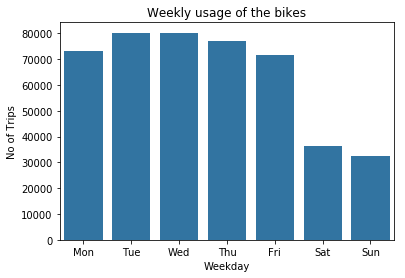

In [85]:

# weekday usage of bikes
cl= sb.color_palette()[0]
weekday = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
sb.countplot(data=gobike_df, x='start_time_weekday', color = cl, order = weekday)
plt.xlabel('Weekday')
plt.ylabel('No of Trips')
plt.title('Weekly usage of the bikes');

#### The bike share system is mainly used during weekdays, with Tuesday and Wednesday being popular days for bike rides. This takes us a step closer to our previous anlysis where we expected the short ride times to be associated with work place commute.We will further explore the hour of the rides.

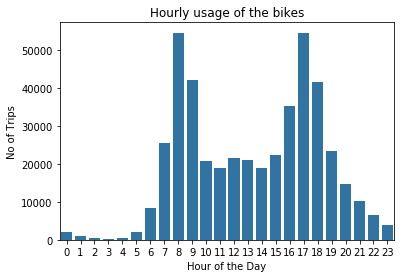

In [86]:
# Hourly usage of bikes
cl= sb.color_palette()[0]
#weekday = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
sb.countplot(data=gobike_df, x='start_time_hour', color = cl)
plt.xlabel('Hour of the Day')
plt.ylabel('No of Trips')
plt.title('Hourly usage of the bikes');

#### The hourly distribution is bimodal, Maximum no of rides are between 8AM -9 AM and  5PM -6PM which suggests they use this for work place commute.8AM and 5 PM is the most popular time for rides.

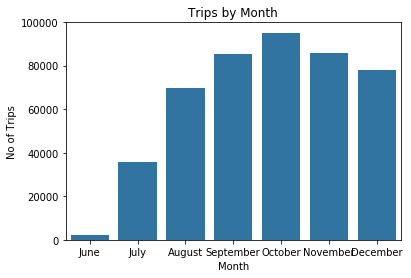

In [87]:
##### Let us look at the monthly usage of the bikes
cl= sb.color_palette()[0]
sb.countplot(data=gobike_df,x='start_time_month_name',color=cl);
plt.xlabel('Month')
plt.ylabel('No of Trips')
plt.title('Trips by Month');



#### We do not have a lot of data for June so we can ignore that but we can see that the number of rides gradually increase after July and October is the peak season.It starts to decrease after that.Weather probably is the factor.

#### Let us understand the age group of our riders

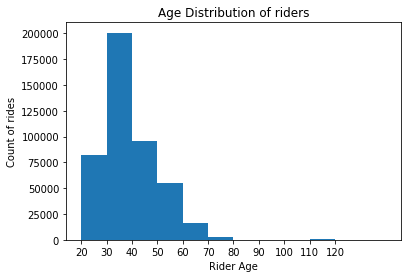

In [88]:
binsize = 10
bins = np.arange(gobike_df['member_age'].min(), gobike_df['member_age'].max()+binsize, binsize)
plt.hist(data = gobike_df, x = 'member_age', bins = bins);
plt.xlabel('Rider Age')
plt.ylabel('Count of rides')
plt.xticks([20,30,40,50,60,70,80,90,100,110,120])
plt.title('Age Distribution of riders');

#### The histogram shows that the age of most of our riders is between 20 and 40.30- 40 being the peak and it dips after that .There are some unusually high age entries above 100 which is causing the long right tail.We will see how many of these exists and remove that from our dataset since that is very unlikely possibility.


In [89]:
## No of riders above 100
len(gobike_df[gobike_df.member_age > 100 ])


382

In [90]:
gobike_df = gobike_df[gobike_df.member_age <= 100 ]

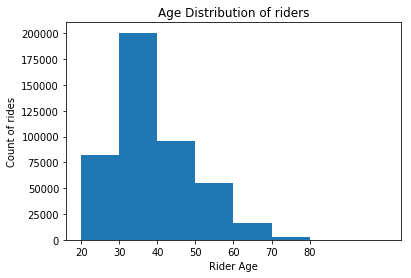

In [91]:
### Let us replot the graph
binsize = 10
bins = np.arange(gobike_df['member_age'].min(), gobike_df['member_age'].max()+binsize, binsize)
plt.hist(data = gobike_df, x = 'member_age', bins = bins);
plt.xlabel('Rider Age')
plt.ylabel('Count of rides')
plt.xticks([20,30,40,50,60,70,80])
plt.title('Age Distribution of riders');

### Before we end there are 2 more variables to explore user type and gender

In [92]:
### let us calculate the proportions of user tyoe
# calculating % split for the user type
customer_count = len(gobike_df[gobike_df.user_type == "Customer"])
subscriber_count = len(gobike_df[gobike_df.user_type == "Subscriber"])

customer_proportion = customer_count / len(gobike_df)
subscriber_proportion = subscriber_count / len(gobike_df)

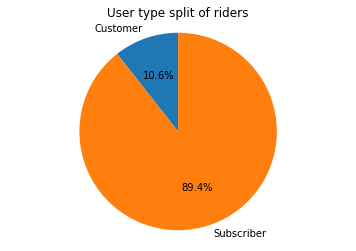

In [93]:
### Plot a pie chart to understand the user type distribution of our riders
labels = ['Customer', 'Subscriber']
sizes = [customer_proportion, subscriber_proportion]
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
plt.axis('equal')
plt.title('User type split of riders');


#### 89% of our riders are subscribers/members

In [94]:
### let us calculate the proportions of user gender

male_count = len(gobike_df[gobike_df.member_gender == "Male"])
female_count = len(gobike_df[gobike_df.member_gender == "Female"])
other_count = len(gobike_df[gobike_df.member_gender == "Other"])

male_proportion = male_count / len(gobike_df)
female_proportion = female_count / len(gobike_df)
other_proportion = other_count / len(gobike_df)


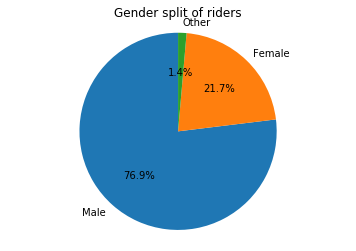

In [95]:
### Plot a pie chart to understand the gender distribution of our riders
labels = ['Male', 'Female', 'Other']
sizes = [male_proportion, female_proportion,other_proportion]
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
plt.axis('equal')
plt.title('Gender split of riders');


#### Most of our riders are male.

#### Discuss the distribution(s) of your variable(s) of interest. Were there any unusual points? Did you need to perform any transformations?

While looking at the trip duration some outliers were observed.The number of entries with trip duration > 15000 s were were very less so were removed for safety.Even after this the histogram was skekewed right so we adjusted the bin size and xticks to explore our data of interest.

#### Of the features you investigated, were there any unusual distributions? Did you perform any operations on the data to tidy, adjust, or change the form of the data? If so, why did you do this?

When investigating the age distribution a number of outlier points were identified. Users above 100 years of age can be characterized as unlikely. For safety, these records were removed from the dataset to move forwards.



## Bivariate Exploration

To start off with, Let us add user type to the weekly usage of bike rides


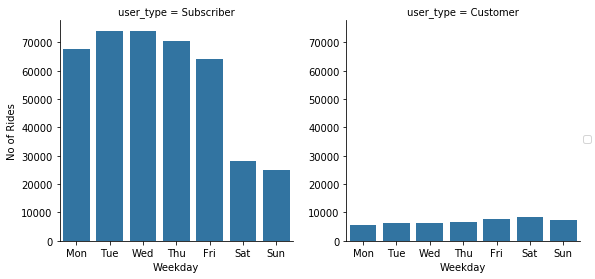

In [96]:
# weekday usage of the bike sharing system per user type

#sb.countplot(data = gobike_df, x = 'start_time_weekday')

weekday= ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
g =sb.FacetGrid(data=gobike_df,col='user_type',size=4,aspect=1);
g.map(sb.countplot,'start_time_weekday',order=weekday)
g.set_axis_labels("Weekday", "No of Rides")
g.add_legend()

#### Though the number of customer rides are less compared to subscribers, we can see that subscribers use the ride mostly during weekdays whereas the customers use the ride more in the weekends, saturday being the most popular day which suggests they are mostly tourists or casual riders.It will be interesting to see the ride duration of customers during weekdays to understand the purpose of their commute and see what offers or discounts will encourage them to subscribe.

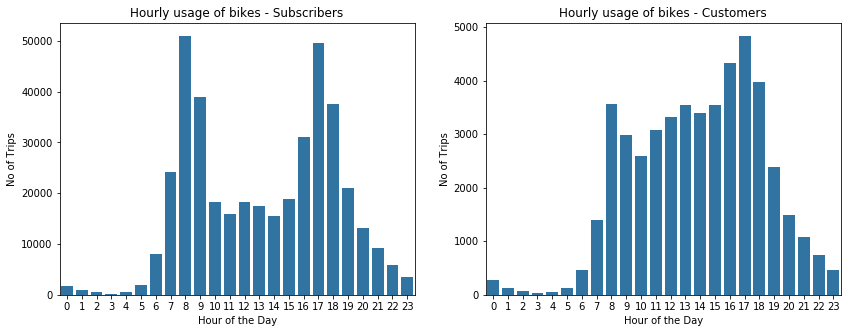

In [97]:
 # hourly usage of the bikes per user type
plt.figure(figsize=[14,5]) 
cl= sb.color_palette()[0]
sub_gobike_df = gobike_df[gobike_df.user_type == 'Subscriber']
cust_gobike_df = gobike_df[gobike_df.user_type == 'Customer']
plt.subplot(1,2,1)
sb.countplot(data=sub_gobike_df, x='start_time_hour', color = cl)
plt.xlabel('Hour of the Day')
plt.ylabel('No of Trips')
plt.title('Hourly usage of bikes - Subscribers');
plt.subplot(1,2,2)
sb.countplot(data=cust_gobike_df, x='start_time_hour', color = cl)
plt.xlabel('Hour of the Day')
plt.ylabel('No of Trips')
plt.title('Hourly usage of bikes - Customers');

#### The shape of the histogram is different for Subscribers and Customers. Customers use bikes mainly between 8 am - 9 pm and 5 PM - 6 PM. Customers use bikes throughout the day with 5 PM being the peak.

/opt/conda/lib/python3.6/site-packages/pandas/core/indexing.py:1472: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


Text(0,0.5,'Ride Duration')

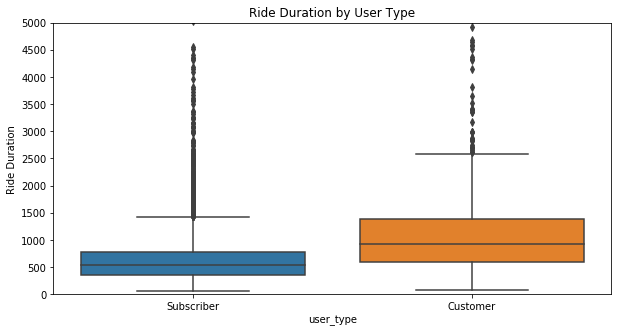

In [98]:
# plot to understand ride duration by customer type
#sample 10000 rides so that plots are clearer and they render faster
samples = np.random.choice(gobike_df.shape[0], 10000, replace = False)
gobike_df_sample = gobike_df.loc[samples,:]

plt.figure(figsize=[10,5])
sb.boxplot(data=gobike_df_sample, x = 'user_type',y= 'duration_sec');
plt.ylim(0,5000)
plt.yticks([0,500,1000,1500,2000,2500,3000,3500,4000,4500,5000]);
plt.title('Ride Duration by User Type')
plt.ylabel('Ride Duration')



#### Customers clearly spend more time riding than the subscribers.The median ride duration of customers is almost double the median ride duration of a subscriber.This suggestests that most of the customers are tourists who take long trips

#### Talk about some of the relationships you observed in this part of the investigation. How did the feature(s) of interest vary with other features in the dataset?
Adding the user type to the analysis helped us understnad the differnece in usage behaviours between customers and subscribers. Customers are casual riders, most probably tourists who rent bikes through out the day more during weekends to go around the city. Most of the subscribers are daily commuters who rent bikes to get to work/school on weekdays during the rush office hours  (8-9am and 5-6pm).

#### Did you observe any interesting relationships between the other features (not the main feature(s) of interest)?
Though customers do not ride as frequently as subscribers, their trip duration is much more longer than the subscribers.

## Part VI - Multivariate Exploration
In this section I will further explore the dataset by adding gender to the customer type and check the usage of bike rides for customers and subscribers.



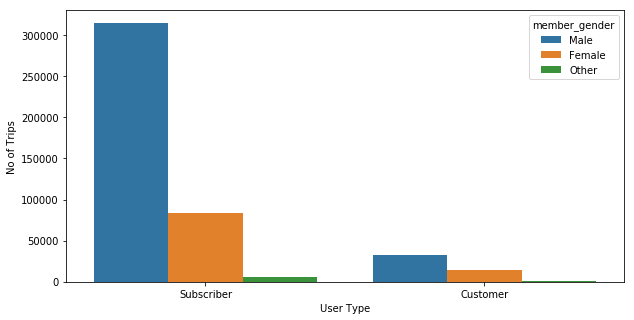

In [99]:
plt.figure(figsize = [10, 5])

# code for the bar chart
g = sb.countplot(data=gobike_df, x="user_type", hue="member_gender")
g.set_xlabel('User Type')
g.set_ylabel('No of Trips');

#### The proportion of female is much lesser than the proportion of male in subscribers but the gender ratio is not that huge with customers.Male Vs Female ratio for customers  is approximately 2:1.

#### Let us add gender to trip duration by user type to see if we observe any interesting pattern

/opt/conda/lib/python3.6/site-packages/pandas/core/indexing.py:1472: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


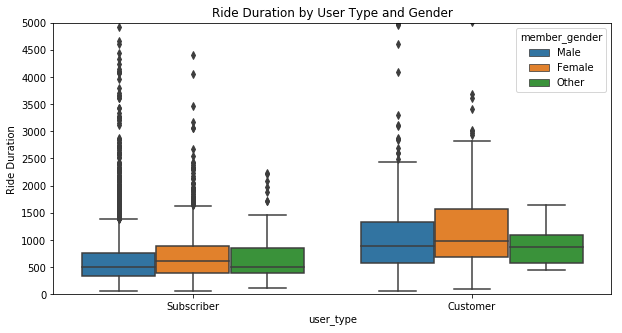

In [100]:
# plot to understand ride duration by customer type by gender
#sample 10000 rides so that plots are clearer and they render faster
samples = np.random.choice(gobike_df.shape[0], 10000, replace = False)
gobike_df_sample = gobike_df.loc[samples,:]

plt.figure(figsize=[10,5])
sb.boxplot(data=gobike_df_sample, x = 'user_type',y= 'duration_sec', hue='member_gender');
plt.ylim(0,5000)
plt.yticks([0,500,1000,1500,2000,2500,3000,3500,4000,4500,5000]);
plt.title('Ride Duration by User Type and Gender')
plt.ylabel('Ride Duration');


#### It is intersting to find out that the median ride duration in both subscriber and customer category is almost similar for Male and Other gender but female riders tend to have longer ride duration in both subscriber and customer categories.

In [101]:
# let us filter the dataframe to have customers only
customer_gobike_df = gobike_df[(gobike_df.user_type=='Customer')]



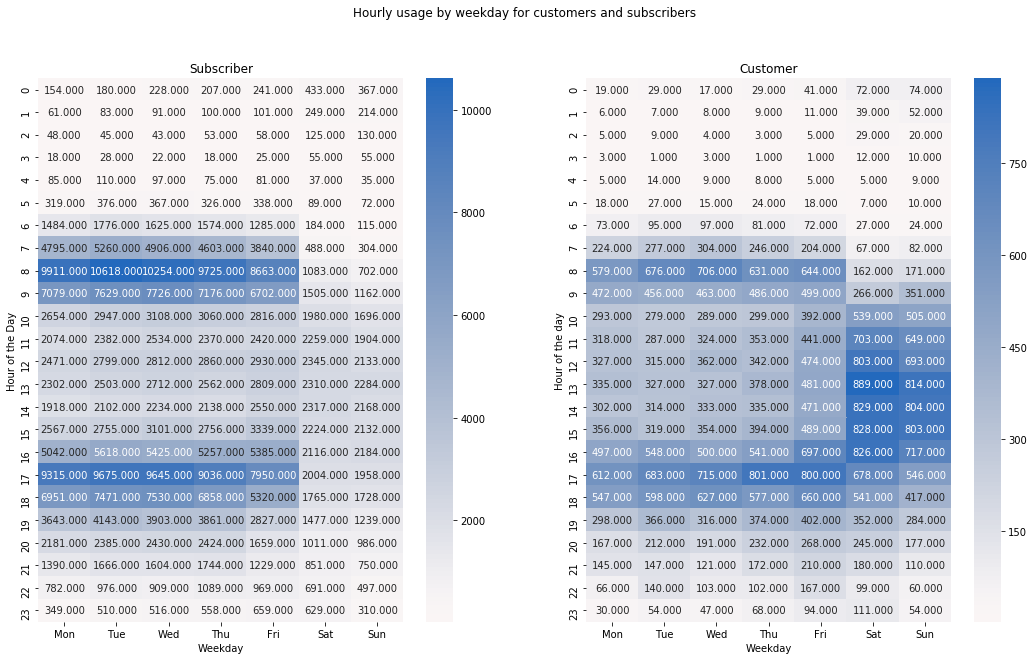

In [102]:
plt.figure(figsize=(18,10))
customer_gobike_df = gobike_df[(gobike_df.user_type=='Customer')]
subscriber_gobike_df = gobike_df[(gobike_df.user_type=='Subscriber')]
plt.suptitle('Hourly usage by weekday for customers and subscribers')

# heatmap for subscribers
plt.subplot(1, 2, 1)
subscriber_df = subscriber_gobike_df.groupby(["start_time_hour", "start_time_weekday"])["bike_id"].size().reset_index()
subscriber_df = subscriber_df.pivot("start_time_hour", "start_time_weekday", "bike_id")
sb.heatmap(subscriber_df, annot = True, fmt = '.3f',
cmap = 'vlag_r',center=0)

plt.title("Subscriber")
plt.xlabel('Weekday')
plt.ylabel('Hour of the Day');

# heatmap for customers
plt.subplot(1, 2, 2)
customer_df = customer_gobike_df.groupby(["start_time_hour", "start_time_weekday"])["bike_id"].size().reset_index()
customer_df = customer_df.pivot("start_time_hour", "start_time_weekday", "bike_id")
sb.heatmap(customer_df, annot = True, fmt = '.3f',
cmap = 'vlag_r',center=0)

plt.title("Customer")
plt.xlabel('Weekday')
plt.ylabel('Hour of the day');




#### The left heatmap above shows bike usage by subscribers and the right heatmap above shows bike usage by customers. The customer heatmap shows that customers use bikes mainly during weekends, specifically between 12 PM and 4 PM.Saturday 1 PM seems to be the most popular time. Customers do use bikes during weekdays more frequently around 8-9am and 4-6pm with the peak on Thursdays around 5pm.

#### The subscriber heatmap shows that the users almost always use the bikes for office commute, given the times of the day of bike usage. Also, the subscriber bike usage is always concentrated to the weekdays, which goes to show that majority of the subscribers do not use bikes for reasons other than for commuting to work.Tueday 8 AM being the peak

#### Talk about some of the relationships you observed in this part of the investigation. Were there features that strengthened each other in terms of looking at your feature(s) of interest?

When we plotted the rides by weekday and rides by hour of the day idividually for each user type we found the below
Subscribers
Popular Day - Tuesday,Wednesday
Pupular Hour of the Day - 8AM and 5PM

Customers
Popular Day - Saturday
Pupular Hour of the Day - 5PM

Plotting a heat map for number of rides with all the variables together (Time of the day,Weekday) showed us that most of the customers use bikes on weekends  between 12 PM and 4 PM peaking on Saturdays at 1 PM.
Plotting variables together gave us more insight into customer behavior

#### Were there any interesting or surprising interactions between features?
Adding gender to the User type by no of rides gave us an interesting fact that though almost 50% of customers are female, the percentage of female is only about 32% in the subscriber category which suggests through women rent bikes during weekends, not many women (compared to men)  use bikes for office commute.However by adding gender to our ride duration by user type we found that the average ride duration of women is more than men in both the subscriber and customer category.

In [103]:
gobike_df.to_csv('clean_gobike.csv',index=False)
customer_df.to_csv('clean_customer.csv',index=False)
subscriber_df.to_csv('clean_subscriber.csv',index=False)